# Regressions using raster data and predictors of point process intensity

The theme for this week was "cross-sectional analysis," but as we saw on Tuesday that's not entirely correct becuase one topic we covered (pointwise regression), uses time series data. Really, the main thing linking all of the statistical analysis methods we discussed on Tuesday is that they all use raster data to predict something. Often that something is another rasterized field, but in the case of the Poisson model we covered at the end it is the intensity of a point process. 

In terms of the python tools we'll use, we've mostly seen them before. The two new things are `sliding_window_view` from `numpy.lib.stride_tricks`, which we'll use for Moving Window Regression and `sklearn.linear_model`, which will provide `LinearRegression` to estimate OLS regressions and `PoissonRegressor` to numerically solve for the Poisson regression parameter estimates.

Let's start by simulating some data we'll use to test out these methods. For basic raster regression, we just need a two-band raster. To make it a little interesting, we'll introduce a known correlation and see if we can get an estimate close to it.

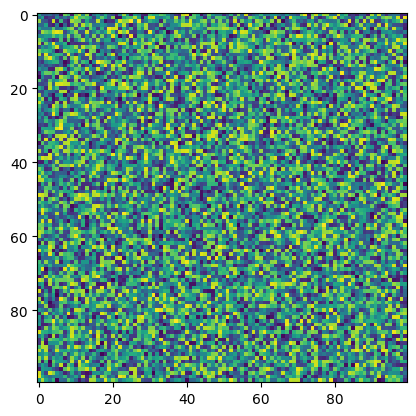

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, PoissonRegressor

r = np.random.rand(100,100,2) # 100 x 100 raster with 2 bands
r[:,:,1] = r[:,:,0] + (r[:,:,1]-0.5)*.1 # Introduce correlation between bands
# since rand is on [0,1] subtracting 0.5 makes its expected value 0. We multiply by 0.1 so the "noise" component is relatively small
# if band 0 is X and band 1 is Y, we have Y = 1 * X + e where e ~ U[-0.05,0.05]
# So we want to recover a coefficient close to 1

Y = r[:,:,1]
plt.imshow(Y)

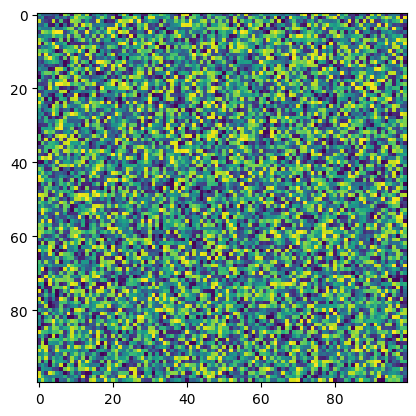

In [128]:
X = r[:,:,0]
plt.imshow(X)

Hard to tell how strong the correlation is just eye balling it. Let's make a scatter plot instead.

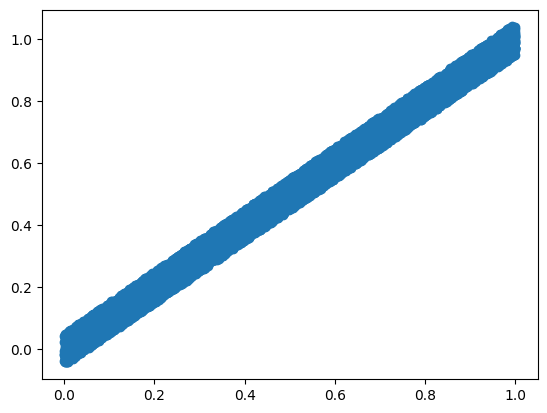

In [129]:
X = np.ravel(X) # Flatten it from 2D to 1D
Y = np.ravel(Y)

plt.scatter(X,Y)

Very strong correlation (as we intended). Now let's estimate OLS. The documentation for `LinearRegression` is [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). The most notable argument is probably `fit_intercept`, which determines whether we include a term like $\alpha$ in the models we've written.

The way we use `LinearRegression` is somewhat strange. We first make a `LinearRegression` model and choose e.g. should it include an intercept. Then we use the `fit` method to estimate the parameters, which then get stored in the attributes `coef_` and `intercept_`.

In [130]:
ols = LinearRegression() # Make an OLS estimator
ols.fit(X.reshape(-1, 1), # it expects a two dimensional array, the first for rows and second for columns
        Y)
ols.coef_ # Should be close to 1

array([0.99993094])

In [117]:
ols.intercept_ # Should be close to 0

np.float64(-0.00048593628909465725)

Now that we've seen how to turn raster data into something like tabular data and estimate OLS regressions, let's move on to moving window regression. As mentioned in class, the idea is similar except we choose a small "window" of the raster to estimate on and move that window around.

Here, we'll use `sliding_window_view` (documentation [here](https://numpy.org/doc/stable/reference/generated/numpy.lib.stride_tricks.sliding_window_view.html)) to make the window and slide it around. We give `sliding_window` an array and the shape of the window and it does all the work of making the different "views" of the array for us.

In [118]:
from numpy.lib.stride_tricks import sliding_window_view

r_window = sliding_window_view(r,(5,5,2))
r_window.shape

(96, 96, 1, 5, 5, 2)

Here, there are 96 entries in the first and second dimension because there are 2 of the 100 on each side that cannot accomodate a 5x5 window around it. So `r_window[0,0,0,:,:,:]` is the 5x5x2 sub-array centered at `r[3,3,:]`.

We can estimate OLS on each window and save the coefficients to a new raster to visualize them. As before, all coefficients should be 1 and all intercepts 0, but in this case the small sample sizes will introduce more variance in the estimates.

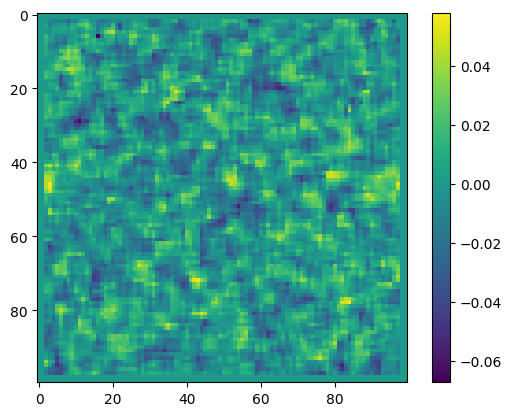

In [121]:
def ols_subarr(i,j):
    '''
    function to estimate OLS on a 5x5x2 sub-array of r cenetered at i,j
    '''

    subarr = r_window[i-2,j-2,0,:,:,:] # Get the relevant sub array (need to subtract 3, see text above)
    X = subarr[:,:,0].ravel() # Make 1D again
    Y = subarr[:,:,1].ravel()

    ols = LinearRegression() 
    ols.fit(X.reshape(-1, 1), Y)

    return(np.array([ols.intercept_,ols.coef_[0]])) # We'll keep both the intercept and coefficient to put into a new array
    #coef_ is an array so need to grab the value

r_mw_ests = np.zeros((100,100,2))

for i in range(2,98):
    for j in range(2,98):
        r_mw_ests[i,j,:] = ols_subarr(i,j)

im = plt.imshow(r_mw_ests[:,:,0])
plt.colorbar(im)

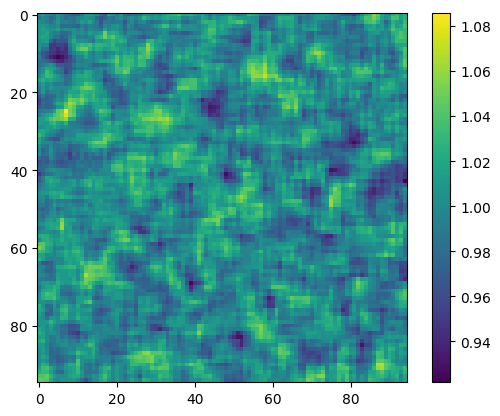

In [120]:
im = plt.imshow(r_mw_ests[3:98,3:98,1]) # Easier to see the variation if we don't include the 0s since these are closer to 1
plt.colorbar(im)

Compared to moving window regression, pointwise regression is a piece of cake! The only additional wrinkle of complexity is we need another dimension to keep track of time steps. So our indices will be (row, column, band, time). Again, we'll introduce a little correlation and see if we can recover it. This time, the true coefficient on X will be the row index.

In [123]:
dvf = np.random.rand(10,10,2,100) # 10 x 10 raster with 2 bands and 100 time steps
for row in range(0,10):
    dvf[row,:,1,:] = row*dvf[row,:,0,:] + 0.1*(dvf[row,:,1,:]-0.5)

dvf.shape

(10, 10, 2, 100)

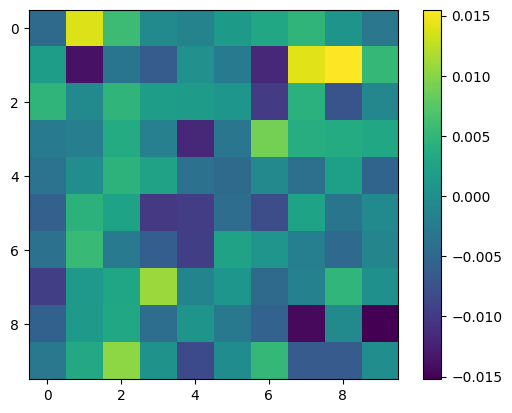

In [124]:
pwise_arr = np.zeros((10,10,2)) # This will hold the results of our pointwise regression

for i in range(0,10):
    for j in range(0,10):
        X = dvf[i,j,0,:]
        Y = dvf[i,j,1,:]

        ols = LinearRegression() 
        ols.fit(X.reshape(-1, 1), Y)

        pwise_arr[i,j,:] = np.array([ols.intercept_,ols.coef_[0]])

im = plt.imshow(pwise_arr[:,:,0])
plt.colorbar(im)

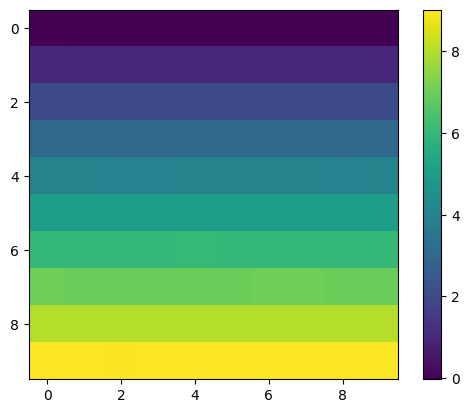

In [125]:
im = plt.imshow(pwise_arr[:,:,1])
plt.colorbar(im)

Last up, we have the Poisson point process predictor model. We need to do two things to test this out. First, we need to simulate some points. To make it interesting, we should have the intensity be correlated with the raster value. To accomplish this, we'll use a trick from probability. We'll draw three numbers uniformly on `[0,1]x[0,1]`. We'll then assign the points to pixels based on the cumulative share of the raster values (e.g. if we drew 0.1, we'd cumulatively add up the pixel values and divide by the total sum of pixel values until we got a number greater than 0.1), and then the other two numbers will determine the position of the point within the pixel. These last two numbers are mostly for aesthetics, for the purposes of estimating the regression we only need to assign points to pixels.

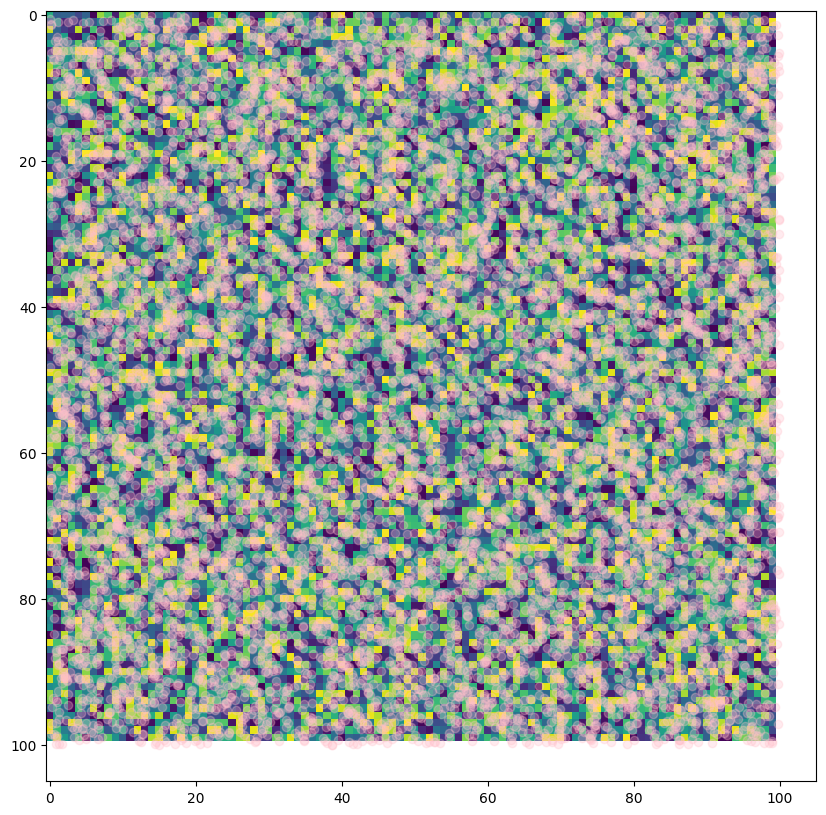

In [131]:
xtot = np.sum(X)
xp = np.cumsum(X)/xtot # total probability


points = np.random.rand(10000,3) # 10,000 points, numbers each

# assign them to pixels
idxs = [np.min(np.where(xp>points[i,0])) for i in range(0,10000)]
idxs = np.unravel_index(idxs, (100,100), order='C')
rs,cs = idxs

p_xs = cs + points[:,1] 
p_ys = rs + points[:,2]

fig, ax = plt.subplots(1,1,figsize=(10,10))

ax.imshow(r[:,:,0])
ax.scatter(p_xs,p_ys,color="#FFC0CB",alpha=0.3)

Okay, now we need to turn this into a usable data set. What we'll do is we'll make a `DataFrame` of row and column indices and count up how many points were assigned to that pixel, along with the raster value. 

In [132]:
import pandas as pd

rs = p_ys//1 # Here we'll pretend like we had just gotten the points and assign them to their row and column indices
cs = p_xs//1


df = []
for row in range(0,100):
    for col in range(0,100):
        point_count = [i for i in range(0,10000) if rs[i]==row and cs[i]==col] # get the points that are assigned to that pixel
        point_count = len(point_count) # How many are there?
        df.append({'row':row,'col':col,'raster':r[row,col,0],
                  'point_count':point_count})

df = pd.DataFrame(df)
df

,row,col,raster,point_count
0,0,0,0.614081,1
1,0,1,0.297783,0
2,0,2,0.313417,1
3,0,3,0.311192,1
4,0,4,0.213279,0
...,...,...,...,...
9995,99,95,0.786644,1
9996,99,96,0.738146,2
9997,99,97,0.798539,1
9998,99,98,0.576852,3


In [133]:
df['point_count'].sum()

np.int64(10000)

<Axes: xlabel='raster', ylabel='point_count'>

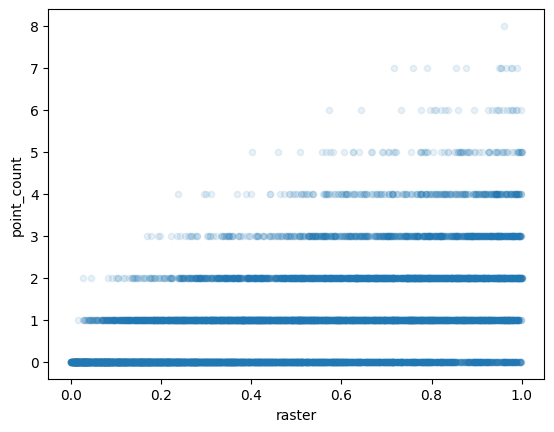

In [135]:
df.plot.scatter(x='raster',y='point_count',alpha=0.1)

Now we fit the Poisson regression! As I mentioned in class, solving for the estimates does not have a closed form solution so we need to use numerical methods. Fortunately, that's already done for us in `PoissonRegressor` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.PoissonRegressor.html)). Like with `LinearModel`, we first choose some details about the model, then fit it. Once fitted, we can see what the estimates are. In this case we should expect the coefficient to be positive.

In [136]:
poisson = PoissonRegressor()
poisson.fit(np.reshape(df['raster'].to_numpy(),(-1,1)),
            df['point_count'])
poisson.coef_

array([0.15850413])

The way you interpret the coefficient is as the percent (proportional change) in the expected number of points for a small increase in X. Importantly, we call this a "linear model" because we estimate something that is linear in terms, but the model of the conditional expectation function is non-linear. That means to have a guess as to how much the expected number of points should increase for a small increase in X, we need to know where